In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import namedtuple
from scipy.interpolate import interp1d
import numpy as np
from itertools import cycle

In [2]:
# Set plotting style
plt.style.use("seaborn-white")

WIDTH = 12
HEIGHT = 7

# Hardcoded Colors
YELLOW_JERSEY_COLOR = "gold"
GREEN_JERSEY_COLOR = "#2ca02c"
POLKADOT_JERSEY_COLOR = "#d62728"
WHITE_JERSEY_COLOR = "black"
LANTERNE_ROUGE_COLOR = "darkred"
OTHER_RIDER_COLOR = "grey"

# Default colors
prop_cycle = plt.rcParams['axes.prop_cycle']
DEFAULT_COLORS = cycle(prop_cycle.by_key()['color'])

%matplotlib inline

In [3]:
def reset_color_cycle():
    return cycle(prop_cycle.by_key()['color'])

In [4]:
DNF = 999

LAST_STAGE = 21

TOUR_YEAR = 2019

# Helper functions

In [5]:
RiderRow = namedtuple("RiderRow", ["rider", "final_place", "x", "y"])

In [6]:
RiderPlotProp = namedtuple("RiderPlotProp", ["color", "y_nudge"], defaults=[OTHER_RIDER_COLOR, 0.])

In [7]:
def make_plot_tuples(df, x_col="stage", y_col="gap_seconds"):
    """Creates a `rider_row` with riders, place, x, and y arrays."""
    # Get stage and final ranks
    finished_riders_by_rank = df[df["stage"]==LAST_STAGE][["rider", "rank"]]
    merged_df = pd.merge(left=df, right=finished_riders_by_rank, how="left", on="rider")
    merged_df = merged_df.rename(columns={"rank_x": "stage_rank", "rank_y": "final_rank"})
    merged_df["final_rank"] = merged_df["final_rank"].fillna(DNF)
    
    ordered_riders = merged_df[merged_df["stage"]==1].sort_values(["final_rank"])[["rider", "final_rank"]].to_numpy()

    # Get the X, Y values for each rider
    rider_rows = []
    for rider, rank in ordered_riders:
        sub_df = merged_df[merged_df["rider"]==rider]
        x = sub_df[x_col].to_numpy()
        y = sub_df[y_col].to_numpy()
        rider_rows.append(RiderRow(rider, rank, x, y))
        
    return rider_rows

In [8]:
def get_zorder_alpha(color):
    alpha = 1
    zorder = 0
    
    if color == OTHER_RIDER_COLOR:
        zorder = -1
        alpha = 0.3
    elif color == YELLOW_JERSEY_COLOR:
        zorder = 1
    
    return zorder, alpha

In [9]:
def plot_line(x, y, color=OTHER_RIDER_COLOR, label=None):
    zorder, alpha = get_zorder_alpha(color)
        
    if label is None or color == OTHER_RIDER_COLOR:
        label = None
    
    plt.step(
        x=x, 
        y=y, 
        linewidth=5, 
        alpha=alpha, 
        zorder=zorder, 
        where="post", 
        color=color,
        label=label,
    )

In [10]:
def plot_points(x, y, color=OTHER_RIDER_COLOR, label=None):
    zorder, alpha = get_zorder_alpha(color)
  
    xnew = np.linspace(1, LAST_STAGE, num=1000, endpoint=True)
    cubic = interp1d(x, y, kind='cubic')
  
    if label is None or color == OTHER_RIDER_COLOR:
        label = None

    plt.plot(
        x, y, "-",
        #xnew, cubic(xnew), "-",
        alpha=alpha, 
        zorder=zorder, 
        color=color,
        markersize=7.5,
        linewidth=5,
        label=label,
    )

In [11]:
def draw_legend(fig):
    """Draw the legend on the specified plot."""
    legend_properties = {
        'weight':'bold',
        'size': 30,
    }
    
    leg = plt.legend(
        loc="lower left",
        ncol=1,
        frameon=False,
        # The bellow commands remove the lines in the legend
        handlelength=0,
        handletextpad=0,
        markerscale=0,
        prop=legend_properties,
    )

    # Set the legend text color to match the line color
    lines = leg.get_lines()
    texts = leg.get_texts()
    for text, line in zip(texts, lines):
        text.set_color(line.get_color())

    fig.tight_layout()

In [12]:
def draw_left_legend(ax):
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    
    ys = [l.get_ydata()[-1] for l in ax.lines]
    labels = []
    for line in ax.lines:
        label = line.get_label()
        if label.startswith("_"):
            label = None
        labels.append(label)
        
    ax2.set_yticks(ys)
    ax2.set_yticklabels(labels)

    colors = [l.get_color() for l in ax.lines]
    
    for tick, color in zip(ax2.get_yticklabels(), colors):
        tick.set_color(color)
        tick.set_size(20)

In [13]:
def draw_left_legend2(ax, special_riders):
    for line in ax.lines:
        label = line.get_label()
        if label.startswith("_"):
            continue
        
        try:
            y_nudge = special_riders[label].y_nudge
        except KeyError:
            y_nudge = 0
        
        color = line.get_color()
        y = line.get_ydata()[-1]
        x = line.get_xdata()[-1]
        
        ax.annotate(
            s=label,
            xy=(x, y),
            xytext=(x+.3, y+y_nudge),
            color=color,
            size=20,
            weight="bold",
            va="center"
        )

In [14]:
def make_plot(rider_rows, top_n=None, max_minute=None, special_riders={}, title=f"Tour de France {TOUR_YEAR}"):
    fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

    # Set titles
    plt.title(title, fontsize=30)
    ax.set_ylabel("Minutes Behind the Leader", fontsize=20)
    ax.set_xlabel("Stage", fontsize=20)

    # Set the ticks to be every stage
    stages = tuple(range(1, 22))
    ax.set_xticks(stages)
    
    ax.tick_params(axis='both', which='major', labelsize=15)

    #plot_2d_hist(rider_rows)
    for rider, place, x, y in rider_rows:
        color = OTHER_RIDER_COLOR
        if place == 1:
            color = YELLOW_JERSEY_COLOR
        elif rider in special_riders:
            color = special_riders[rider].color
        elif top_n is not None and place > top_n and color == OTHER_RIDER_COLOR:
            continue

        #plot_line(x, y, color, label=rider)
        plot_points(x, y, color, label=rider)

    # Set ticks on the y axis
    if max_minute is not None:
        ax.set_ylim(-0.25, max_minute)
    #ax.set_yticks(range(0, 420, 60))
    #plt.yscale('symlog') 

    #draw_legend(fig)
    plt.gca().invert_yaxis()
    draw_left_legend2(ax, special_riders)
    
    sns.despine(trim=True)
       
    if top_n is not None:
        filename = f"/tmp/{TOUR_YEAR}_tour_de_france_top_{top_n}."
    else:
        filename = f"/tmp/{TOUR_YEAR}_tour_de_france."

    # Save to disk
    for ext in ("png", "svg"):
        fig.savefig(
            f"{filename}{ext}", bbox_inches="tight"
        )

# Load the data

In [15]:
df = pd.read_json(f"./data/{TOUR_YEAR}-tdf-dataframe.json", orient="table")

In [16]:
df["gap_minutes"] = df["gap_seconds"] / 60
df["gap_hours"]   = df["gap_seconds"] / 3600

In [17]:
rider_rows = make_plot_tuples(df, x_col="stage", y_col="gap_minutes")

# Make the plots

In [18]:
DEFAULT_COLORS = reset_color_cycle()

TOP_SPECIAL_RIDERS = {
            "Geraint Thomas": RiderPlotProp(next(DEFAULT_COLORS)),
            "Julian Alaphilippe": RiderPlotProp(next(DEFAULT_COLORS)),   
            "Steven Kruijswijk": RiderPlotProp(next(DEFAULT_COLORS)),
            "Emanuel Buchmann": RiderPlotProp(next(DEFAULT_COLORS)),
}

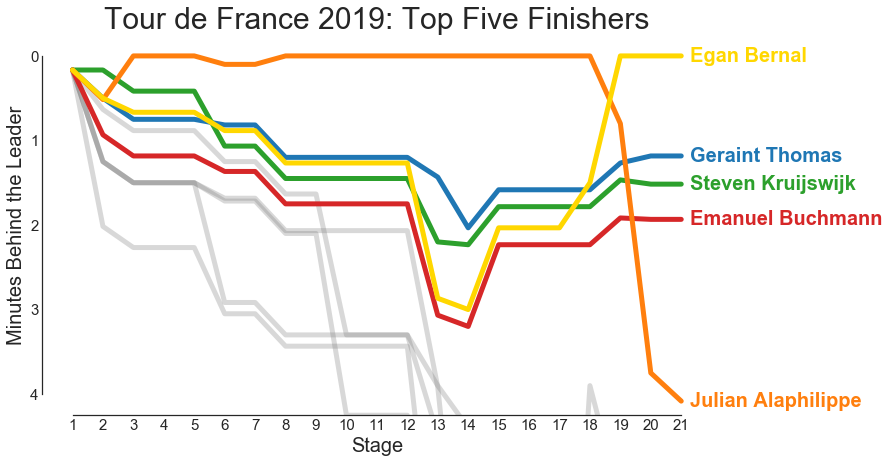

In [22]:
make_plot(
    rider_rows, 
    top_n=5, 
    max_minute=4.251, 
    special_riders=TOP_SPECIAL_RIDERS,
    title="Tour de France 2019: Top Five Finishers"
)

In [20]:
DEFAULT_COLORS = reset_color_cycle()

SPECIAL_RIDERS = {
    "Peter Sagan": RiderPlotProp(GREEN_JERSEY_COLOR),
    "Romain Bardet": RiderPlotProp(POLKADOT_JERSEY_COLOR, +3),
    "Yoann Offredo": RiderPlotProp(next(DEFAULT_COLORS), -10),
    "Sebastian Langeveld": RiderPlotProp(LANTERNE_ROUGE_COLOR),
    "Julian Alaphilippe": RiderPlotProp(next(DEFAULT_COLORS), +13), 
}

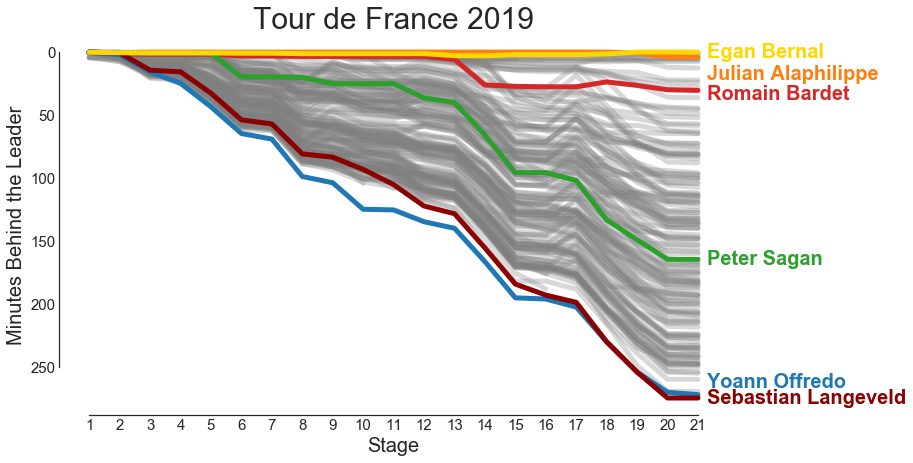

In [21]:
make_plot(rider_rows, special_riders=SPECIAL_RIDERS)